# <center>CMSC320 - Final Project (need better title)</center>
<center>Michael Reeve and Sambit Sahoo</center>

## <center>Introduction</center>





In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import json
import requests

In [2]:
# we have 10 CSVs from https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual
# need to group all data into one dataframe
# loop over all files and concat them into eachother
df_final = pd.DataFrame()

for i in range(12,23):
    curr_df = pd.read_csv(f"aqi_data_by_year/annual_aqi_by_county_20{i}.csv")
    df_final = pd.concat([df_final, curr_df])

df_final.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2012,284,226,56,2,0,0,0,112,61,38,0,0,210,74,0
1,Alabama,Clay,2012,121,99,22,0,0,0,0,72,56,35,0,0,0,121,0
2,Alabama,Colbert,2012,283,222,55,6,0,0,0,136,62,40,0,0,209,74,0
3,Alabama,DeKalb,2012,361,282,74,5,0,0,0,115,64,40,0,0,320,41,0
4,Alabama,Elmore,2012,245,212,33,0,0,0,0,100,54,40,0,0,245,0,0


In [3]:
# check for missing data (NaNs)
# every column should be 0
df_final.isna().sum()

State                                  0
County                                 0
Year                                   0
Days with AQI                          0
Good Days                              0
Moderate Days                          0
Unhealthy for Sensitive Groups Days    0
Unhealthy Days                         0
Very Unhealthy Days                    0
Hazardous Days                         0
Max AQI                                0
90th Percentile AQI                    0
Median AQI                             0
Days CO                                0
Days NO2                               0
Days Ozone                             0
Days PM2.5                             0
Days PM10                              0
dtype: int64

In [4]:
# dataset includes "Country Of Mexico", "Puerto Rico", "Virgin Islands", we need to remove them for our mapping
states = df_final["State"].unique()
print(states)
print(states.size)
# note size is 54, there should be 51 (50 + DC)

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming']
54


In [5]:
# remove unwanted entries
exclude_list = ["Country Of Mexico", "Puerto Rico", "Virgin Islands"]
df_final = df_final[~df_final["State"].isin(exclude_list)]

#confirm size is 51
print(df_final["State"].unique().size)
print(df_final["State"].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District Of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


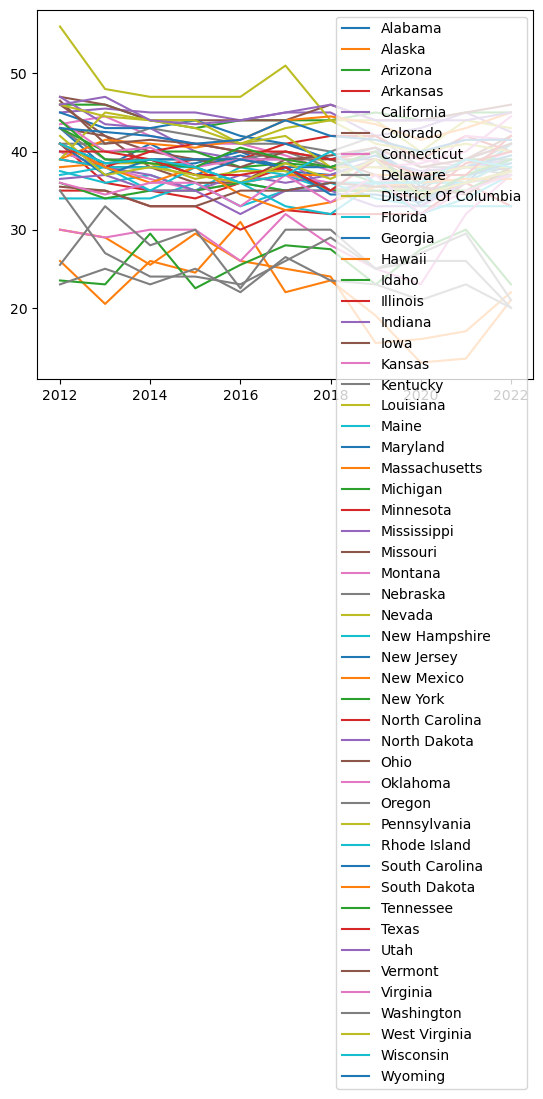

In [33]:
median_states_df = df_final.groupby(by=["Year", "State"], as_index=False).median()
states = median_states_df["State"].unique().tolist()
state_data = {k : [] for k in states}
for s in states:
    for index, row in median_states_df[median_states_df["State"] == s].iterrows():
        state_data[s].append(row["Median AQI"])
        
        
        
        
years = df_final["Year"].unique().tolist()
for k,v in state_data.items():
    plt.plot(years, v, label=k)

plt.legend(loc="best")
plt.show()

In [6]:
# modified from: https://gist.github.com/rogerallen/1583593
STATE_TO_ABR = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District Of Columbia": "DC",
}

In [9]:
state_geo_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"

for year in df_final["Year"].unique():
    state_df = df_final[df_final["Year"] == year].groupby(by="State", as_index=False).median()
    state_df["StateABR"] = state_df["State"].apply(lambda x: STATE_TO_ABR[x])
    m = folium.Map(location=[48, -102], zoom_start=3)
    folium.Choropleth(
        geo_data=state_geo_url,
        data=state_df,
        columns=["StateABR", "Median AQI"],
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="Median AQI",
    ).add_to(m)

    display(m)